# Tema 11: HoLCUs (Hadamard Test over Linear Combination of Unitaries)

En este notebook implementamos **HoLCUs**, una técnica que combina el **Hadamard Test** con la **Combinación Lineal de Unitarias (LCU)** para calcular valores esperados de operadores expresados como combinación lineal de unitarias en un único circuito cuántico midiendo un solo qubit.

**Referencias:**
- Paper: [Fast Expectation Value Calculation Speedup of QAOA: HoLCUs QAOA](https://arxiv.org/abs/2503.01748)
- Código: [HoLCUs_QAOA en GitHub](https://github.com/DOKOS-TAYOS/HoLCUs_QAOA)

**¿Qué vamos a hacer?**
- Combinar el Hadamard Test (notebook 4) con LCU (notebook 9)
- Calcular ⟨ψ|H|ψ⟩ para $H = \sum_{i=0}^{m-1} \alpha_i U_i$ en un solo circuito
- Aplicar a un ejemplo concreto

## Idea central de HoLCUs

Dado un operador (por ejemplo, un Hamiltoniano) expresado como combinación lineal de unitarias:

$$H = \sum_{i=0}^{m-1} \alpha_i U_i$$

queremos calcular el valor esperado $\langle\psi|H|\psi\rangle = \sum_i \alpha_i \langle\psi|U_i|\psi\rangle$.

**Enfoque tradicional:** Ejecutar un Hadamard Test por cada término $U_i$, sumar los resultados ponderados. Requiere $m$ circuitos/mediciones.

**Enfoque HoLCUs:** Insertar el bloque LCU completo **dentro** del Hadamard Test. El operador "$U$" del Hadamard Test es el bloque LCU controlado por el qubit ancilla. La medición de solamente el qubit ancilla nos da $\langle\psi|H|\psi\rangle$ (salvo el factor de normalización). Al contrario que el LCU, este algoritmo no tiene probabilidad de fallar.

**Estructura del circuito:**
1. $H$ en ancilla Hadamard
2. Preparar $|\psi\rangle$ en qubits objetivo
3. **Control-LCU:** aplicar el bloque LCU (preparación de amplitudes, SELECT, deshacer preparación) controlado por la ancilla
4. $H$ en ancilla
5. Medir ancilla → $P(0)$ relacionada con $\text{Re}\langle\psi|H|\psi\rangle$

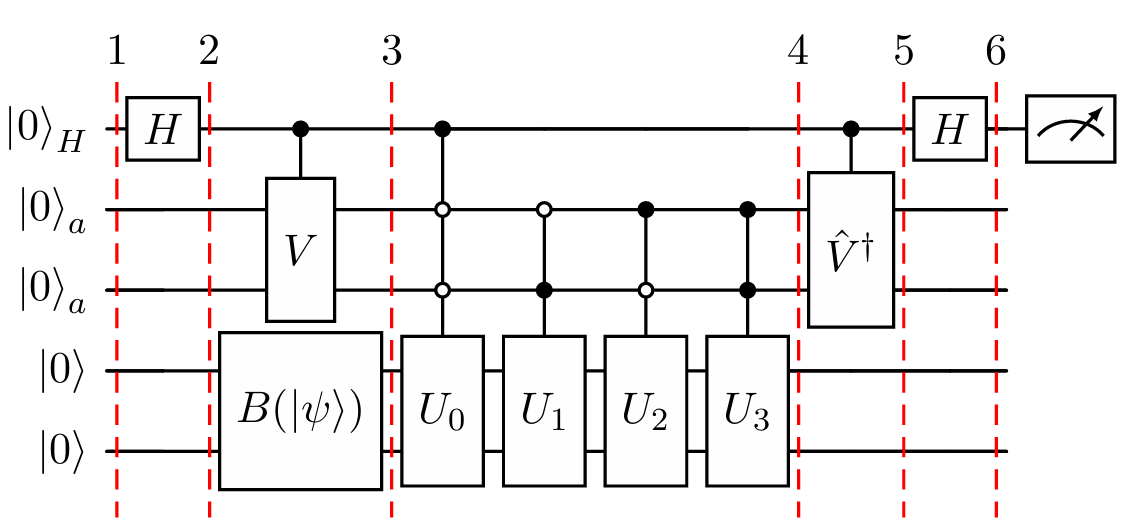

## Desarrollo teórico: deducción de $P(0)$ en el ancilla

Siguiendo el paper [arXiv:2503.01748](https://arxiv.org/abs/2503.01748), mostramos cómo se deduce la probabilidad de medir $|0\rangle$ en el qubit ancilla del Hadamard Test.

### 1. Hadamard Test clásico

Para un operador **unitario** $U$ y estado $|\psi\rangle$, el Hadamard Test calcula $\langle\psi|U|\psi\rangle$. La evolución del circuito (sin $S^\dagger$) es:

1. $|0\rangle_a |\psi\rangle$
2. $\frac{|0\rangle_a + |1\rangle_a}{\sqrt{2}} |\psi\rangle$
3. $\frac{|0\rangle_a}{\sqrt{2}}|\psi\rangle + \frac{|1\rangle_a}{\sqrt{2}} U|\psi\rangle$
4. $\frac{|0\rangle_a}{2}(|\psi\rangle + U|\psi\rangle) + \frac{|1\rangle_a}{2}(|\psi\rangle - U|\psi\rangle)$

Por tanto:
$$P(0) = \frac{1}{2}\bigl(1 + \text{Re}[\langle\psi|U|\psi\rangle]\bigr), \qquad P(1) = \frac{1}{2}\bigl(1 - \text{Re}[\langle\psi|U|\psi\rangle]\bigr)$$

y $\text{Re}[\langle\psi|U|\psi\rangle] = 2P(0) - 1$.

### 2. Operador como LCU

Sea $A$ un operador expresado como combinación lineal de unitarias:
$$A = \sum_{k=0}^{M-1} \alpha_k \xi_k U_k$$
con $\alpha_k \in \mathbb{R}^+$, $\xi_k = e^{i\theta_k}$ y $U_k$ unitarias. Suponemos normalización $\sum_k \alpha_k = 1$ (el caso general se trata al final).

El protocolo LCU usa $m = \lceil\log_2 M\rceil$ qubits ancilla y define:
- $V|0\rangle = \sum_k \sqrt{\alpha_k}\xi_k |k\rangle$
- $\hat{V}|0\rangle = \sum_k \sqrt{\alpha_k}|k\rangle$

Cuando se mide $|0\rangle^{\otimes m}$ en los ancillas del LCU, el estado de trabajo queda proporcional a $A|\psi\rangle$ (el método es probabilístico).

### 3. HoLCUs: Hadamard Test + LCU

La idea es usar el **bloque LCU completo** como el operador "$U$" del Hadamard Test: el LCU se aplica **solo cuando** el ancilla del Hadamard está en $|1\rangle$. Así el operador efectivo sobre $|\psi\rangle$ cuando ancilla$=|1\rangle$ es $A$.

**Registros:** $|x\rangle_H$ (Hadamard), $|y\rangle_a^{\otimes m}$ (LCU), $|z\rangle$ (estado).

**Evolución del estado** (denotando $|x,y,z\rangle = |x\rangle_H |y\rangle_a^{\otimes m} |z\rangle$):

1. $|0\rangle_H |0\rangle_a^{\otimes m} |0\rangle$
2. $\frac{|0\rangle_H + |1\rangle_H}{\sqrt{2}} |0\rangle_a^{\otimes m} |0\rangle$
3. $\frac{1}{\sqrt{2}}\Bigl(|0,0,\psi\rangle + \sum_{k=0}^{M-1} \sqrt{\alpha_k}\xi_k |1,k,\psi\rangle\Bigr)$
4. $\frac{1}{\sqrt{2}}\Bigl(|0,0,\psi\rangle + \sum_{k=0}^{M-1} \sqrt{\alpha_k}\xi_k |1,k,U_k\psi\rangle\Bigr)$
5. $\frac{1}{\sqrt{2}}\Bigl(|0,0,\psi\rangle + |1,0,A\psi\rangle + |1,\perp,A_\perp\psi\rangle\Bigr)$  
   (tras aplicar $\hat{V}^\dagger$: $|0\rangle_a$ da $A|\psi\rangle$, el resto $|A_\perp\psi\rangle$)
6. Tras la segunda Hadamard en el ancilla $H$:
   $$\frac{1}{2}|0,0,(I+A)\psi\rangle + \frac{1}{2}|0,\perp,A_\perp\psi\rangle + \frac{1}{2}|1,0,(I-A)\psi\rangle - \frac{1}{2}|1,\perp,A_\perp\psi\rangle$$

### 4. Probabilidad $P(0)$ en el ancilla Hadamard

Al medir **solo** el qubit Hadamard, la probabilidad de obtener $|0\rangle_H$ es la suma de las normas al cuadrado de todos los términos con $|0\rangle_H$:

$$P(0) = \frac{1}{4}\Bigl(1 + 2\,\text{Re}[\langle A\rangle] + \langle A^\dagger A\rangle + \langle A_\perp\rangle\Bigr)$$

$$P(1) = \frac{1}{4}\Bigl(1 - 2\,\text{Re}[\langle A\rangle] + \langle A^\dagger A\rangle + \langle A_\perp\rangle\Bigr)$$

donde $\langle A\rangle = \langle\psi|A|\psi\rangle$, etc.

**Clave:** Al restar:
$$P(0) - P(1) = \frac{1}{4}\cdot 4\,\text{Re}[\langle A\rangle] = \text{Re}[\langle\psi|A|\psi\rangle]$$

Como $P(0) + P(1) = 1$ (los términos $\langle A^\dagger A\rangle$ y $\langle A_\perp\rangle$ aparecen en ambos y se cancelan en la diferencia), se tiene:
$$\boxed{\text{Re}[\langle\psi|A|\psi\rangle] = 2P(0) - 1}$$

La misma relación que en el Hadamard Test clásico. El método es **determinista** (no hay probabilidad de fallo como en LCU puro) y basta medir **un solo qubit**.

### 5. Caso sin normalización

Si $\sum_{i=0}^{M-1} \alpha_i = N \neq 1$, se trabaja con $A' = A/N$ y:
$$\text{Re}[\langle\psi|A|\psi\rangle] = N\,\text{Re}[\langle\psi|A'|\psi\rangle] = N\bigl(2P(0) - 1\bigr)$$

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np

---
# Implementación

Reutilizamos la función de preparación de amplitudes del notebook de LCU y creamos el circuito HoLCUs que combina Hadamard Test + LCU.

In [2]:
def _preparar_estado_amplitudes(amplitudes: np.ndarray, qubits: list, circuit: QuantumCircuit, inverse: bool = False) -> None:
    """Prepara estado con amplitudes reales usando solo Ry/cry."""
    m = len(qubits)
    amps = np.array(amplitudes[: 2**m], dtype=float)
    amps = amps / np.linalg.norm(amps)

    sgn = -1 if inverse else 1
    eps = 1e-10

    if m == 1:
        # theta = 2 atan2(amp1, amp0)
        theta = sgn * 2 * np.arctan2(amps[1], amps[0])
        circuit.ry(theta, qubits[0])

    elif m == 2:
        a, b, c, d = amps[0], amps[1], amps[2], amps[3]

        # Normas de cada rama del control (|0·> y |1·>)
        n01 = np.hypot(a, b)
        n23 = np.hypot(c, d)

        # Ángulos robustos con atan2 (preservan signos)
        theta0 = sgn * 2 * np.arctan2(n23, n01)
        theta1 = sgn * 2 * np.arctan2(b, a) if n01 > eps else 0.0
        theta2 = sgn * 2 * np.arctan2(d, c) if n23 > eps else 0.0

        if inverse:
            if n23 > eps:
                circuit.cry(theta2, qubits[1], qubits[0])     # control=1
            if n01 > eps:
                circuit.x(qubits[1])                         # ahora control original=0
                circuit.cry(theta1, qubits[1], qubits[0])
                circuit.x(qubits[1])
            circuit.ry(theta0, qubits[1])
        else:
            circuit.ry(theta0, qubits[1])
            if n01 > eps:
                circuit.x(qubits[1])
                circuit.cry(theta1, qubits[1], qubits[0])
                circuit.x(qubits[1])
            if n23 > eps:
                circuit.cry(theta2, qubits[1], qubits[0])

    else:
        raise ValueError("Solo m=1 o m=2 sin transpilación.")

In [4]:
def HoLCUs_circuit(
    n: int,
    state: np.ndarray,
    operator_list: list,
    amplitudes_list: np.ndarray,
    Re: bool = True,
) -> tuple[QuantumCircuit, float]:
    """
    Construye el circuito HoLCUs: Hadamard Test sobre LCU aplicado a |ψ⟩.

    Args:
        n: número de qubits del estado
        state: vector de estado |ψ⟩ (normalizado)
        operator_list: lista de puertas unitarias U_i
        amplitudes_list: coeficientes α_i (reales para Re, pueden ser complejos)
        Re: True para parte real, False para parte imaginaria (requiere S† antes de H final)

    Returns:
        (circuito, factor_normalizacion) con factor = sum(|α_i|)
    """
    m = int(np.ceil(np.log2(len(amplitudes_list))))
    normalization = float(np.sum(np.abs(amplitudes_list)))
    
    # Registros separados para mejor visualización
    anc_h = QuantumRegister(1, "Hadamard")
    anc_lcu = QuantumRegister(m, "LCU_anc")
    qr = QuantumRegister(n, "state")
    cr = ClassicalRegister(1, "meas")
    qc = QuantumCircuit(anc_h, anc_lcu, qr, cr, name="HoLCUs")
    
    # Hadamard en ancilla
    qc.h(anc_h[0])
    qc.barrier()
    
    # Preparar estado |ψ⟩
    qc.initialize(state, list(qr), normalize=True)
    qc.barrier()
    
    # Preparar amplitudes en ancillas LCU (controlado por ancilla Hadamard)
    amplitudesV = np.sqrt(np.abs(amplitudes_list))
    if len(amplitudesV) != 2**m:
        amplitudesV = np.append(amplitudesV, np.zeros(2**m - len(amplitudesV)))
    
    # Primera preparación de estado (controlada)
    prep_gate = QuantumCircuit(m, name="PrepState")
    _preparar_estado_amplitudes(amplitudesV, list(range(m)), prep_gate, inverse=False)
    controlled_prep = prep_gate.to_gate().control(1)
    qc.append(controlled_prep, [anc_h[0]] + list(anc_lcu))
    qc.barrier()
    
    # Aplicar operadores controlados por ancillas LCU (solo cuando anc_h=|1⟩ y i=0)
    for i in range(len(amplitudes_list)):
        binario = bin(i)[2:]
        binario = ("0" * (m - len(binario)) + binario)[::-1]
        
        # Aplicar X donde el bit es 0
        for j, bit in enumerate(binario):
            if bit == "0":
                qc.x(anc_lcu[j])
        
        # Para i=0: controlar con ancilla Hadamard también
        if i == 0:
            controlled_op = operator_list[i].control(m + 1)
            qc.append(controlled_op, [anc_h[0]] + list(anc_lcu) + list(qr))
        else:
            # Para i>0: solo control por ancillas LCU, ya que evidentemente el H estara activo
            controlled_op = operator_list[i].control(m)
            qc.append(controlled_op, list(anc_lcu) + list(qr))
        
        # Deshacer X
        for j, bit in enumerate(binario):
            if bit == "0":
                qc.x(anc_lcu[j])
    
    qc.barrier()
    
    # Segunda preparación de estado inversa (controlada)
    prep_gate_inv = QuantumCircuit(m, name="PrepState†")
    _preparar_estado_amplitudes(amplitudesV, list(range(m)), prep_gate_inv, inverse=True)
    controlled_prep_inv = prep_gate_inv.to_gate().control(1)
    qc.append(controlled_prep_inv, [anc_h[0]] + list(anc_lcu))
    qc.barrier()
    
    # Para parte imaginaria: S† antes de la segunda H
    if not Re:
        qc.sdg(anc_h[0])
    qc.h(anc_h[0])
    qc.barrier()
    
    qc.measure(anc_h[0], cr[0])
    return qc, normalization

In [6]:
def holcus_expectation_value(
    qc: QuantumCircuit,
    normalization: float,
    shots: int = 10000,
    backend=None,
) -> float:
    """
    Ejecuta el circuito HoLCUs y devuelve ⟨ψ|H|ψ⟩.

    Fórmula: ⟨ψ|H|ψ⟩ = (2*P(0) - 1) * normalization
    """
    if backend is None:
        backend = AerSimulator()
    
    transpiled_circuit = transpile(qc, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    probability_zero = counts.get("0", 0) / shots
    expectation_value = (2 * probability_zero - 1) * normalization
    
    return expectation_value

---
# Ejemplo: H = α₁Z₁ + α₂Z₂

Consideramos un Hamiltoniano de 2 qubits: H = (1/3)Z₁ + (2/3)Z₂.  
El valor esperado ⟨ψ|H|ψ⟩ se obtiene en un solo circuito con HoLCUs.

Factor de normalización: 1.0


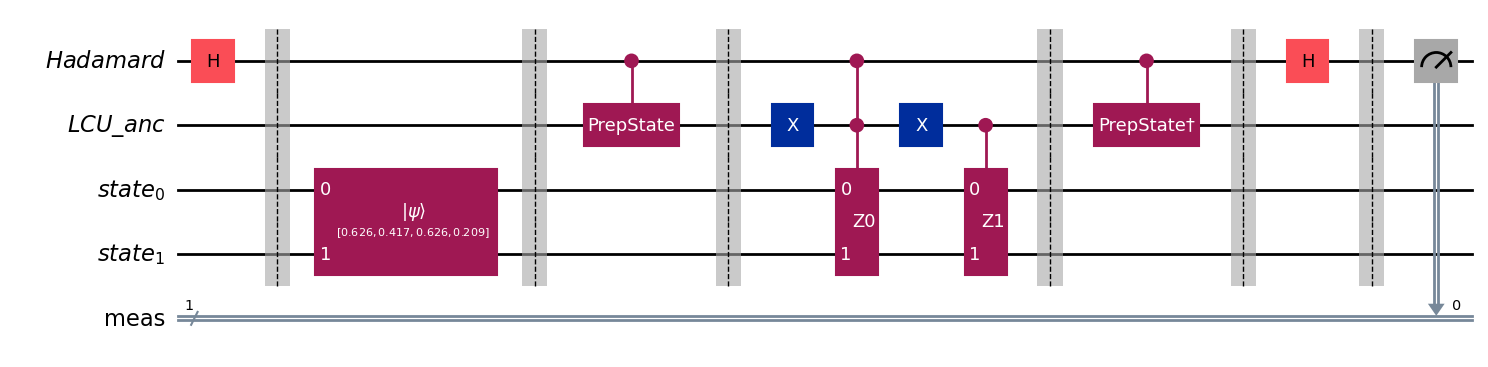

In [7]:
n = 2
amplitudes_list = np.array([1.0 / 3, 2.0 / 3])
# Operadores: Z en qubit 0, Z en qubit 1
op_z0 = QuantumCircuit(n, name="Z0")
op_z0.z(0)
op_z1 = QuantumCircuit(n, name="Z1")
op_z1.z(1)
operator_list = [op_z0.to_gate(), op_z1.to_gate()]
# Estado de prueba
state = np.array([0.6, 0.4, 0.6, 0.2], dtype=complex)
state /= np.linalg.norm(state)
qc_holcus, norm = HoLCUs_circuit(n, state, operator_list, amplitudes_list, Re=True)
print(f"Factor de normalización: {norm}")
qc_holcus.draw("mpl")

In [8]:
# Valor teórico: ⟨ψ|H|ψ⟩ = (1/3)⟨ψ|Z₁|ψ⟩ + (2/3)⟨ψ|Z₂|ψ⟩
# Para un estado |ψ⟩ = Σ c_i |i⟩, ⟨ψ|Z_j|ψ⟩ = Σ (-1)^(bit j de i) |c_i|²
def valor_teorico_ising(state: np.ndarray, coefs: np.ndarray, posiciones: list[list[int]]) -> float:
    """Calcula ⟨ψ|H|ψ⟩ para H = Σ coefs[k] * Z en posiciones[k]."""
    n = int(np.log2(len(state)))
    val = 0.0
    for k, (coef, pos) in enumerate(zip(coefs, posiciones)):
        for i in range(len(state)):
            sign = 1
            for p in pos:
                # Verifica si el bit en la posición p del número i está en 1
                # (i >> p) desplaza i hacia la derecha p posiciones
                # & 1 extrae el bit menos significativo (0 o 1)
                # Ejemplo: si i=5 (binario 101) y p=0, (5>>0)&1 = 1
                #          si i=5 (binario 101) y p=1, (5>>1)&1 = 0
                #          si i=5 (binario 101) y p=2, (5>>2)&1 = 1
                if (i >> p) & 1:
                    sign *= -1
            val += coef * sign * (np.abs(state[i]) ** 2)
    return val

posiciones = [[0], [1]]  # Z en qubit 0, Z en qubit 1
teorico = valor_teorico_ising(state, amplitudes_list, posiciones)
print(f"Valor teórico ⟨ψ|H|ψ⟩ = {teorico:.6f}")

Valor teórico ⟨ψ|H|ψ⟩ = 0.275362


In [ ]:
exp_holcus = holcus_expectation_value(qc_holcus, norm, shots=10000)
print(f"HoLCUs (1 circuito):  ⟨ψ|H|ψ⟩ ≈ {exp_holcus:.6f}")
print(f"Diferencia con teórico: {abs(exp_holcus - teorico):.6f}")

HoLCUs (1 circuito):  ⟨ψ|H|ψ⟩ ≈ 0.268600
Diferencia con teórico: 0.006762


## Comparación: HoLCUs vs Hadamard Test por término

Con el enfoque tradicional haríamos 2 circuitos (uno por cada Z) y sumaríamos. Con HoLCUs usamos **un solo circuito**.

In [10]:
# Enfoque tradicional: Hadamard Test por cada término (como en notebook 4)
def hadamard_circuit(n: int, state: np.ndarray, U, Re: bool = True) -> QuantumCircuit:
    anc = QuantumRegister(1, "ancilla")
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(1, "c")
    qc = QuantumCircuit(anc, qr, cr, name="Hadamard")
    qc.h(anc[0])
    qc.initialize(state, list(qr), normalize=True)
    controlU = U.control(1)
    qc.append(controlU, [anc[0]] + list(qr))
    if not Re:
        qc.sdg(anc[0])
    qc.h(anc[0])
    qc.measure(anc[0], cr[0])
    return qc

# Hadamard Test para Z₀ y Z₁ por separado
backend = AerSimulator()
ht_z0 = hadamard_circuit(n, state, op_z0.to_gate(), Re=True)
ht_z1 = hadamard_circuit(n, state, op_z1.to_gate(), Re=True)
exp_z0 = (2 * (backend.run(transpile(ht_z0, backend), shots=5000).result().get_counts().get("0", 0) / 5000) - 1)
exp_z1 = (2 * (backend.run(transpile(ht_z1, backend), shots=5000).result().get_counts().get("0", 0) / 5000) - 1)
exp_tradicional = amplitudes_list[0] * exp_z0 + amplitudes_list[1] * exp_z1
print(f"Tradicional (2 circuitos): ⟨ψ|H|ψ⟩ ≈ {exp_tradicional:.6f}")
print(f"HoLCUs (1 circuito):       ⟨ψ|H|ψ⟩ ≈ {exp_holcus:.6f}")

Tradicional (2 circuitos): ⟨ψ|H|ψ⟩ ≈ 0.266933
HoLCUs (1 circuito):       ⟨ψ|H|ψ⟩ ≈ 0.268600
